In [113]:
import pandas as pd

df = pd.read_csv("Sentiment_Data.csv", encoding='ISO-8859-1') 
df.head()

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [115]:
df['Sentiment'].unique()

array(['Mild_Pos', 'Strong_Pos', 'Neutral', 'Strong_Neg', 'Mild_Neg'],
      dtype=object)

In [117]:
!pip install spacy  emoji

In [119]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.6 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [121]:
import re
import pandas as pd
import spacy
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize stopwords set and Stemmer
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/mukulgarg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mukulgarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
# Define a dictionary of common slangs and abbreviations
slang_dict = {
    "u": "you",
    "r": "are",
    "pls": "please",
    "omg": "oh my god",
    "btw": "by the way",
    "idk": "i don't know",
    "lmao": "laughing my ass off",
    "brb": "be right back",
    "lol": "laugh out loud",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "bff": "best friends forever",
    "ttyl": "talk to you later"
}

In [127]:
!pip install symspellpy

In [3]:
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import spacy
import emoji
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import defaultdict
import unicodedata
from tqdm import tqdm
from symspellpy.symspellpy import SymSpell, Verbosity

In [141]:
# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

# Spell correction using SymSpell
def spell_correct(token):
    suggestions = sym_spell.lookup(token, Verbosity.CLOSEST, max_edit_distance=2)
    return suggestions[0].term if suggestions else token

# Text cleaning and preprocessing function
def clean_text(text):
    if pd.isnull(text):
        return ""

    text = text.lower()

In [143]:
# Full preprocessing function
def clean_text(text):
    if pd.isnull(text): 
        return ""
    text = text.lower()

    # Normalize unicode junk early
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("utf-8", "ignore")

    # Step 1: Remove unwanted patterns
    text = re.sub(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', '<IP>', text)
    text = re.sub(r'http\S+|www\.\S+', '<URL>', text)
    text = re.sub(r'\S+@\S+', '<EMAIL>', text)
    text = re.sub(r'@\w+', '<USER>', text)
    text = re.sub(r'<.*?>', '', text)
    text = emoji.replace_emoji(text, replace=' <EMOJI> ')

    # Step 2: Tokenize and expand slang
    tokens = word_tokenize(text)
    tokens = [slang_dict.get(tok, tok) for tok in tokens]

    # Step 3: Spell correction
    tokens = [spell_correct(tok) for tok in tokens]

    # Step 4: POS tagging and NER using SpaCy
    doc = nlp(" ".join(tokens))
    allowed_postags = {"NOUN", "VERB", "ADJ", "PROPN"}
    named_entities = {ent.text for ent in doc.ents}

    # Step 5–6: Lemmatize, filter POS, remove stopwords
    final_tokens = []
    for token in doc:
        if token.text in named_entities or token.pos_ in allowed_postags:
            if token.text not in stop_words and token.is_alpha:
                final_tokens.append(token.lemma_.lower())

    return " ".join(final_tokens)

In [145]:
df.shape

(451332, 2)

In [147]:
# Drop rows where both Tweet and Sentiment are missing
df = df[~(df['Tweet'].isna() & df['Sentiment'].isna())]
df = df.drop_duplicates(subset=['Tweet'])

df.shape

(451280, 2)

In [151]:
# Add progress bar
tqdm.pandas()

import time
start_time = time.time()

# Apply cleaning
df['clean_text'] = df['Tweet'].progress_apply(clean_text)

end_time = time.time()
print(f"Preprocessing completed in {end_time - start_time:.2f} seconds")

100%|██████████████████████████████████| 451280/451280 [32:16<00:00, 232.99it/s]

Preprocessing completed in 1936.89 seconds


In [152]:
df.head()

,Tweet,Sentiment,clean_text
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos,happy anniversary day freedom die tune mclean ...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos,happy anniversary day freedom die tune mclean ...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos,happy anniversary day freedom die tune mclean ...
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos,happy anniversary day freedom die tune mclean ...
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos,happy anniversary day freedom die tune mclean ...


In [153]:
df['clean_text'].head()

0    happy anniversary day freedom die tune mclean ...
1    happy anniversary day freedom die tune mclean ...
2    happy anniversary day freedom die tune mclean ...
3    happy anniversary day freedom die tune mclean ...
4    happy anniversary day freedom die tune mclean ...
Name: clean_text, dtype: object

In [157]:
df.to_csv("Sentiment_Data_with_clean_text.csv", index=False, encoding='utf-8')


In [1]:
import pandas as pd
df = pd.read_csv("Sentiment_Data_with_clean_text.csv", encoding='utf-8')
print(df.columns)

Index(['Tweet', 'Sentiment', 'clean_text'], dtype='object')


In [2]:
df['Sentiment'].unique()

array(['Mild_Pos', 'Strong_Pos', 'Neutral', 'Strong_Neg', 'Mild_Neg'],
      dtype=object)

In [3]:
#Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import re, emoji, unicodedata
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

Relabelling

In [4]:
# Relabel for 3-class task
def simplify_sentiment(sent):
    if 'Pos' in sent: return 'Positive'
    elif 'Neg' in sent: return 'Negative'
    else: return 'Neutral'

df['Sentiment_3'] = df['Sentiment'].apply(simplify_sentiment)
df.dropna(subset=['clean_text'], inplace=True)

In [5]:
df.head()


,Tweet,Sentiment,clean_text,Sentiment_3
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos,happy anniversary day freedom die tune mclean ...,Positive
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos,happy anniversary day freedom die tune mclean ...,Positive
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos,happy anniversary day freedom die tune mclean ...,Positive
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos,happy anniversary day freedom die tune mclean ...,Positive
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos,happy anniversary day freedom die tune mclean ...,Positive


Train-Test Split

In [6]:
df['Sentiment_3'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [7]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
tqdm.pandas()  # enables progress_apply

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
import numpy as np

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment_3'])

# Step 1: Train+Val and Test split (80% / 20%)
X_temp_text, X_test_text, y_temp, y_test = train_test_split(
    df['clean_text'], y,
    test_size=0.2, stratify=y, random_state=42
)

# Step 2: Train and Val split (90% / 10% of 80%)
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_temp_text, y_temp,
    test_size=0.1111, stratify=y_temp, random_state=42
)

# Tokenization (fit ONLY on training text)
vocab_size = 10000
max_len = 250

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq   = tokenizer.texts_to_sequences(X_val_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

# Padding
X_train = pad_sequences(X_train_seq, maxlen=max_len, truncating='post')
X_val   = pad_sequences(X_val_seq, maxlen=max_len, truncating='post')
X_test  = pad_sequences(X_test_seq, maxlen=max_len, truncating='post')

# Final shape checks
print(f"Train set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Train set: 320558
Validation set: 40066
Test set: 90156


In [ ]:
import pickle
import os
save_dir = "./processed_data/"
os.makedirs(save_dir, exist_ok=True)

np.save(f"{save_dir}X_train.npy", X_train)
np.save(f"{save_dir}X_test.npy", X_test)
np.save(f"{save_dir}y_train.npy", y_train)
np.save(f"{save_dir}y_test.npy", y_test)
np.save(f"{save_dir}X_val.npy", X_val)
np.save(f"{save_dir}y_val.npy", y_val)

with open(f"{save_dir}tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open(f"{save_dir}label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

df.to_csv(f"{save_dir}Cleaned_Dataset.csv", index=False)

In [10]:
class TweetDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Wrap into PyTorch datasets
train_data = TweetDataset(X_train, y_train)
val_data   = TweetDataset(X_val, y_val)
test_data  = TweetDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=16)
test_loader  = DataLoader(test_data, batch_size=16)


In [11]:
class NonCausalTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.max_len = max_len

    def forward(self, x):
        positions = torch.arange(0, self.max_len).unsqueeze(0).to(x.device)
        x = self.embedding(x) + self.pos_embedding(positions)
        x = x.permute(1, 0, 2)  # (seq_len, batch, embed_dim)
        out = self.transformer(x)
        out = out.mean(dim=0)  # (batch, embed_dim)
        return self.fc(out)


In [12]:
from tqdm import tqdm
import time
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, save_path="model.pth"):
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(epochs):
        start_epoch = time.time()
        model.train()
        total_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", total=len(train_loader))

        for i, (X_batch, y_batch) in enumerate(loop):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=total_loss / (i + 1))

        end_epoch = time.time()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Time: {end_epoch - start_epoch:.2f} sec")

        # Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                preds = output.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        val_acc = correct / total
        print(f"Validation Accuracy: {val_acc:.4f}")

        # Save the model if validation accuracy improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with validation accuracy: {val_acc:.4f}")

    print("Training complete.")

In [13]:
# Usage example:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NonCausalTransformer(
    vocab_size=vocab_size,
    embed_dim=64,
    num_heads=4,
    hidden_dim=128,
    num_layers=2,
    num_classes=3,
    max_len=max_len
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, save_path="best_model.pth")

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1: 100%|██████████| 20035/20035 [18:24<00:00, 18.15it/s, loss=0.611]


Epoch 1/5, Loss: 0.6113, Time: 1104.13 sec
Validation Accuracy: 0.7914
Model saved with validation accuracy: 0.7914


Epoch 2: 100%|██████████| 20035/20035 [18:32<00:00, 18.01it/s, loss=0.534]


Epoch 2/5, Loss: 0.5343, Time: 1112.36 sec
Validation Accuracy: 0.8023
Model saved with validation accuracy: 0.8023


Epoch 3: 100%|██████████| 20035/20035 [18:33<00:00, 18.00it/s, loss=0.511]


Epoch 3/5, Loss: 0.5115, Time: 1113.07 sec
Validation Accuracy: 0.8042
Model saved with validation accuracy: 0.8042


Epoch 4: 100%|██████████| 20035/20035 [18:09<00:00, 18.39it/s, loss=0.496]


Epoch 4/5, Loss: 0.4956, Time: 1089.38 sec
Validation Accuracy: 0.8108
Model saved with validation accuracy: 0.8108


Epoch 5: 100%|██████████| 20035/20035 [18:18<00:00, 18.24it/s, loss=0.483]


Epoch 5/5, Loss: 0.4832, Time: 1098.40 sec
Validation Accuracy: 0.8107
Training complete.


In [14]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

NonCausalTransformer(
  (embedding): Embedding(10000, 64, padding_idx=0)
  (pos_embedding): Embedding(250, 64)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [15]:
model

NonCausalTransformer(
  (embedding): Embedding(10000, 64, padding_idx=0)
  (pos_embedding): Embedding(250, 64)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, data_loader, device, label_encoder=None, return_report=False, plot_cm=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    if label_encoder:
        all_preds_labels = label_encoder.inverse_transform(all_preds)
        all_true_labels = label_encoder.inverse_transform(all_labels)
    else:
        all_preds_labels = all_preds
        all_true_labels = all_labels

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"Accuracy: {accuracy:.4f}")

    if return_report and label_encoder:
        print(classification_report(all_true_labels, all_preds_labels, target_names=label_encoder.classes_))

    if plot_cm and label_encoder:
        cm = confusion_matrix(all_true_labels, all_preds_labels, labels=label_encoder.classes_)
        plt.figure(figsize=(7,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    return accuracy


Train set evaluation:
Accuracy: 0.8272


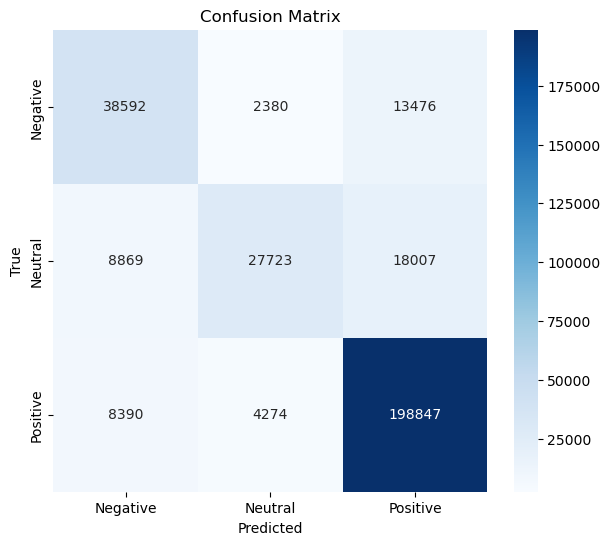


Validation set evaluation:
Accuracy: 0.8108


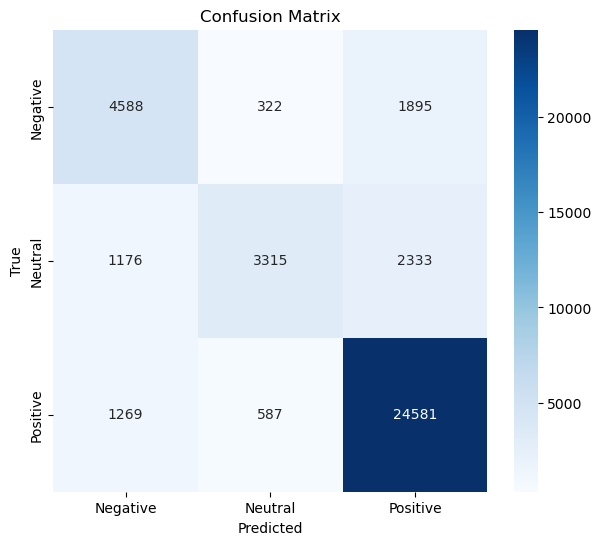


Test set evaluation:
Accuracy: 0.8108
              precision    recall  f1-score   support

    Negative       0.66      0.67      0.67     15313
     Neutral       0.77      0.48      0.59     15356
    Positive       0.85      0.93      0.89     59487

    accuracy                           0.81     90156
   macro avg       0.76      0.69      0.72     90156
weighted avg       0.81      0.81      0.80     90156



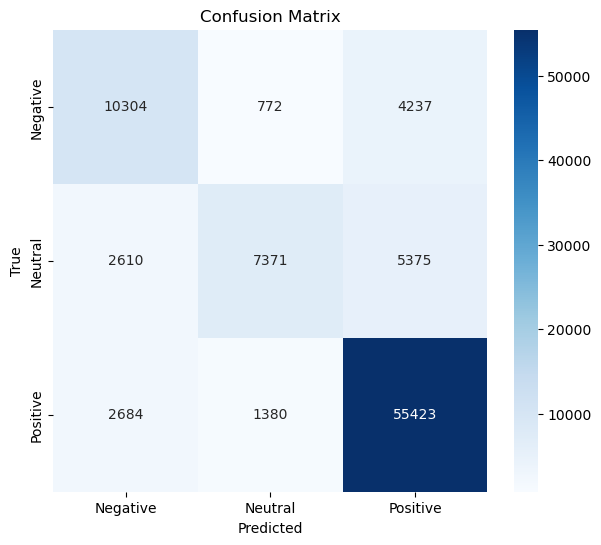

0.8107946226540663

In [17]:
print("Train set evaluation:")
evaluate(model, train_loader, device, label_encoder)

print("\nValidation set evaluation:")
evaluate(model, val_loader, device, label_encoder)

print("\nTest set evaluation:")
evaluate(model, test_loader, device, label_encoder, return_report=True)


Train ROC AUC:


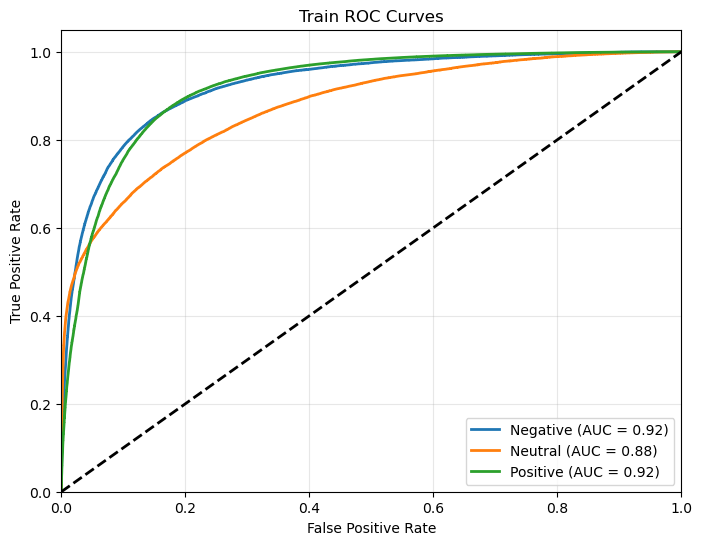

Validation ROC AUC:


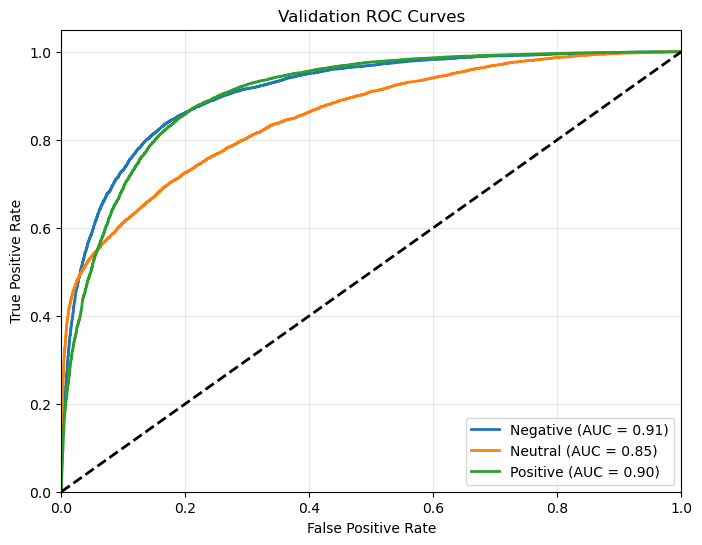

Test ROC AUC:


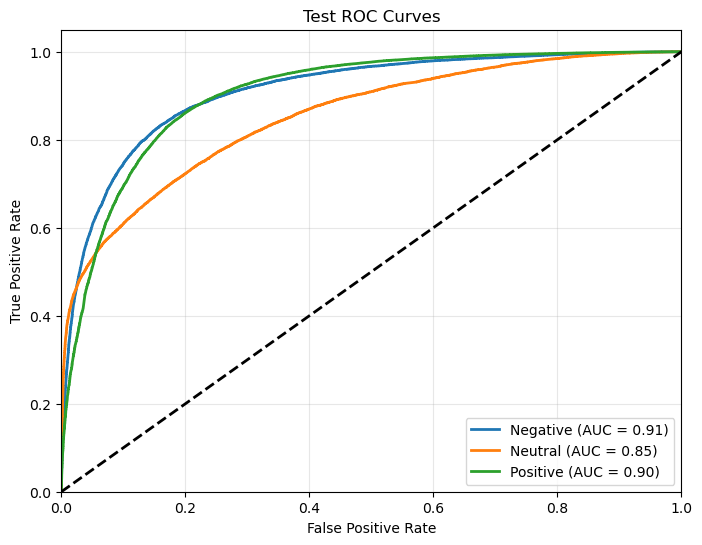

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_auc(model, data_loader, device, label_encoder, title="ROC Curves"):
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            probs = torch.softmax(output, dim=1)  # get probabilities
            all_outputs.append(probs.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    y_score = np.vstack(all_outputs)
    y_true = np.array(all_labels)
    classes = label_encoder.classes_
    n_classes = len(classes)

    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Call this for train, val, test sets after training
print("Train ROC AUC:")
plot_roc_auc(model, train_loader, device, label_encoder, title="Train ROC Curves")

print("Validation ROC AUC:")
plot_roc_auc(model, val_loader, device, label_encoder, title="Validation ROC Curves")

print("Test ROC AUC:")
plot_roc_auc(model, test_loader, device, label_encoder, title="Test ROC Curves")


In [19]:
import time
import os

# Ensure save_dir ends with separator
if not save_dir.endswith(os.sep):
    save_dir += os.sep

start_time = time.time()
# --- Your preprocessing pipeline runs here ---
processing_time = time.time() - start_time

summary = f"""
PREPROCESSING SUMMARY
================================

Dataset Information:
- Total tweets: {len(df):,}
- Train set: {len(X_train):,}
- Validation set: {len(X_val):,}
- Test set: {len(X_test):,}
- Vocabulary size: {vocab_size:,}
- Processing time: {processing_time:.2f} seconds
- Processing speed: {len(df) / processing_time:.0f} tweets/second

Preprocessing Steps Completed:
✓ Emoji processing (converted to text)
✓ Non-grammatical symbol removal
✓ Named Entity Recognition (used to keep entities)
✓ Spell correction (applied)
✓ Abbreviation expansion
✓ Contraction expansion
✓ Punctuation cleaning
✓ Tokenization
✓ Lemmatization



Configuration and data saved to: {save_dir}
"""

summary_path = os.path.join(save_dir, "SUMMARY.txt")
with open(summary_path, "w") as f:
    f.write(summary)

print(summary)
print("PREPROCESSING COMPLETE")
print(f"All data saved to: {save_dir}")



PREPROCESSING SUMMARY

Dataset Information:
- Total tweets: 450,780
- Train set: 320,558
- Validation set: 40,066
- Test set: 90,156
- Vocabulary size: 10,000
- Processing time: 0.00 seconds
- Processing speed: 32045904358 tweets/second

Preprocessing Steps Completed:
✓ Emoji processing (converted to text)
✓ Non-grammatical symbol removal
✓ Named Entity Recognition (used to keep entities)
✓ Spell correction (applied)
✓ Abbreviation expansion
✓ Contraction expansion
✓ Punctuation cleaning
✓ Tokenization
✓ Lemmatization



Configuration and data saved to: ./processed_data/

PREPROCESSING COMPLETE
All data saved to: ./processed_data/


Class distribution in Train set:
  2: 211511 samples (65.98%)
  1: 54599 samples (17.03%)
  0: 54448 samples (16.99%)

Class distribution in Validation set:
  2: 26437 samples (65.98%)
  1: 6824 samples (17.03%)
  0: 6805 samples (16.98%)

Class distribution in Test set:
  2: 59487 samples (65.98%)
  1: 15356 samples (17.03%)
  0: 15313 samples (16.99%)



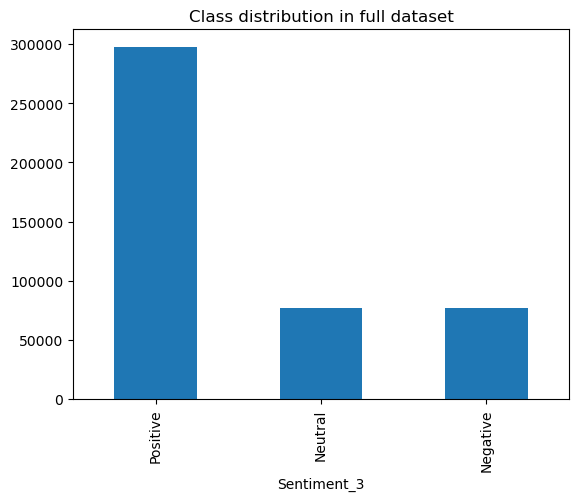

In [21]:
import pandas as pd

def print_class_distribution(labels, name="Dataset"):
    counts = pd.Series(labels).value_counts()
    total = len(labels)
    print(f"Class distribution in {name}:")
    for label, count in counts.items():
        print(f"  {label}: {count} samples ({count/total*100:.2f}%)")
    print()

print_class_distribution(y_train, "Train set")
print_class_distribution(y_val, "Validation set")
print_class_distribution(y_test, "Test set")

import matplotlib.pyplot as plt

df['Sentiment_3'].value_counts().plot(kind='bar', title='Class distribution in full dataset')
plt.show()

# Balancing the Train Set

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Flatten y if needed
y_train_flat = y_train.flatten() if len(y_train.shape) > 1 else y_train

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train_flat)

# Print new distribution
print("After undersampling:")
print_class_distribution(y_train_resampled, "Resampled Train set")


After undersampling:
Class distribution in Resampled Train set:
  0: 54448 samples (33.33%)
  1: 54448 samples (33.33%)
  2: 54448 samples (33.33%)



In [28]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# New DataLoader with balanced data
balanced_train_dataset = TweetDataset(X_train_resampled, y_train_resampled)
balanced_train_loader = torch.utils.data.DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)


In [29]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [30]:
model = NonCausalTransformer(
    vocab_size=vocab_size,
    embed_dim=64,
    num_heads=4,
    hidden_dim=128,
    num_layers=2,
    num_classes=3,
    max_len=max_len
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(
    model,
    balanced_train_loader, 
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=5,
    save_path="noncausal_transformer_balanced.pth"
)


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1: 100%|██████████| 2553/2553 [08:45<00:00,  4.86it/s, loss=0.859]


Epoch 1/5, Loss: 0.8588, Time: 525.44 sec
Validation Accuracy: 0.7255
Model saved with validation accuracy: 0.7255


Epoch 2: 100%|██████████| 2553/2553 [08:54<00:00,  4.78it/s, loss=0.722]


Epoch 2/5, Loss: 0.7218, Time: 534.62 sec
Validation Accuracy: 0.7236


Epoch 3: 100%|██████████| 2553/2553 [08:54<00:00,  4.78it/s, loss=0.677]


Epoch 3/5, Loss: 0.6771, Time: 534.57 sec
Validation Accuracy: 0.7499
Model saved with validation accuracy: 0.7499


Epoch 4: 100%|██████████| 2553/2553 [08:51<00:00,  4.80it/s, loss=0.649]


Epoch 4/5, Loss: 0.6493, Time: 531.38 sec
Validation Accuracy: 0.7311


Epoch 5: 100%|██████████| 2553/2553 [08:51<00:00,  4.80it/s, loss=0.629]


Epoch 5/5, Loss: 0.6291, Time: 531.84 sec
Validation Accuracy: 0.7490
Training complete.


In [32]:
model.load_state_dict(torch.load("noncausal_transformer_balanced.pth"))
model.to(device)

NonCausalTransformer(
  (embedding): Embedding(10000, 64, padding_idx=0)
  (pos_embedding): Embedding(250, 64)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [33]:
model.eval()

NonCausalTransformer(
  (embedding): Embedding(10000, 64, padding_idx=0)
  (pos_embedding): Embedding(250, 64)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

📊 Train Set Evaluation:
Accuracy: 0.7224
              precision    recall  f1-score   support

    Negative       0.67      0.84      0.75     54448
     Neutral       0.85      0.49      0.62     54448
    Positive       0.72      0.83      0.77     54448

    accuracy                           0.72    163344
   macro avg       0.74      0.72      0.71    163344
weighted avg       0.74      0.72      0.71    163344



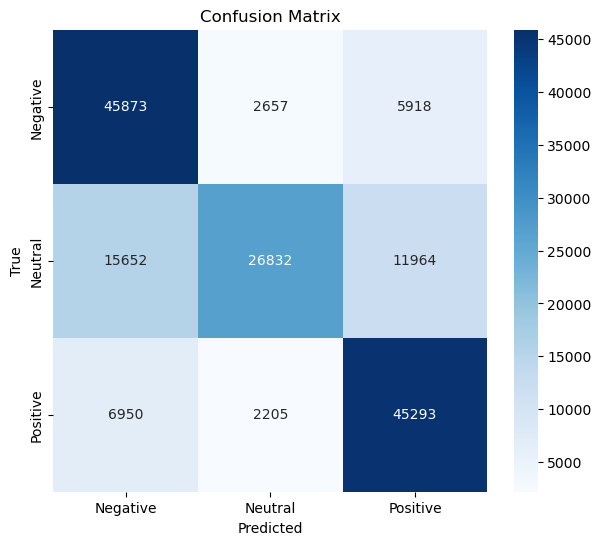

📊 Validation Set Evaluation:
Accuracy: 0.7499
              precision    recall  f1-score   support

    Negative       0.48      0.82      0.61      6805
     Neutral       0.67      0.47      0.56      6824
    Positive       0.90      0.80      0.85     26437

    accuracy                           0.75     40066
   macro avg       0.68      0.70      0.67     40066
weighted avg       0.79      0.75      0.76     40066



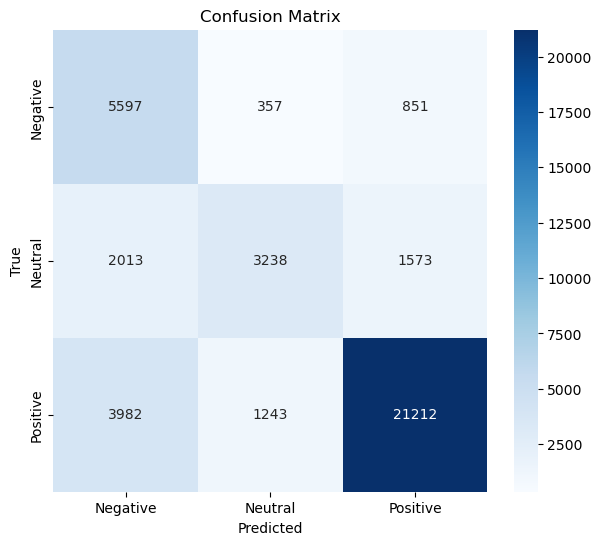

📊 Test Set Evaluation:
Accuracy: 0.7526
              precision    recall  f1-score   support

    Negative       0.49      0.82      0.61     15313
     Neutral       0.66      0.47      0.55     15356
    Positive       0.90      0.81      0.85     59487

    accuracy                           0.75     90156
   macro avg       0.68      0.70      0.67     90156
weighted avg       0.79      0.75      0.76     90156



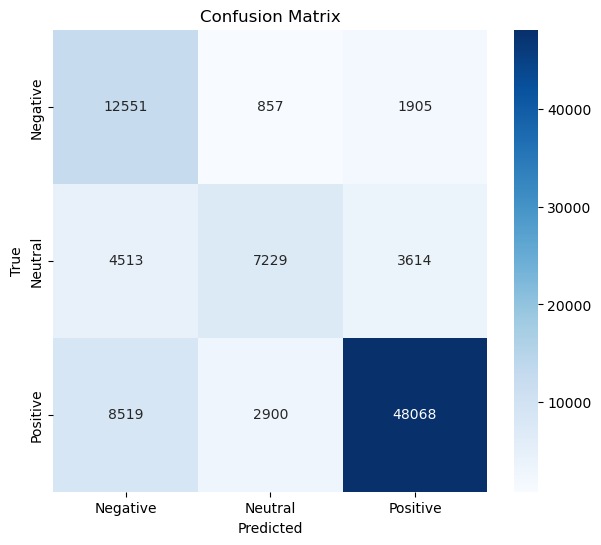

0.7525622254758418

In [34]:
print("📊 Train Set Evaluation:")
evaluate(model, balanced_train_loader, device, label_encoder=label_encoder, return_report=True, plot_cm=True)

print("📊 Validation Set Evaluation:")
evaluate(model, val_loader, device, label_encoder=label_encoder, return_report=True, plot_cm=True)

print("📊 Test Set Evaluation:")
evaluate(model, test_loader, device, label_encoder=label_encoder, return_report=True, plot_cm=True)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_auc(model, data_loader, device, label_encoder=None, title="ROC Curves"):
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)
            probs = torch.softmax(output, dim=1)
            all_outputs.append(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    y_score = np.vstack(all_outputs)
    y_true = np.array(all_labels)

    if label_encoder:
        classes = label_encoder.classes_
        y_true_transformed = label_encoder.transform(classes)
    else:
        classes = np.unique(y_true)
        y_true_transformed = classes

    n_classes = len(classes)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        label = classes[i] if label_encoder else str(i)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


ROC AUC Curves for balanced dataset
Train ROC AUC:


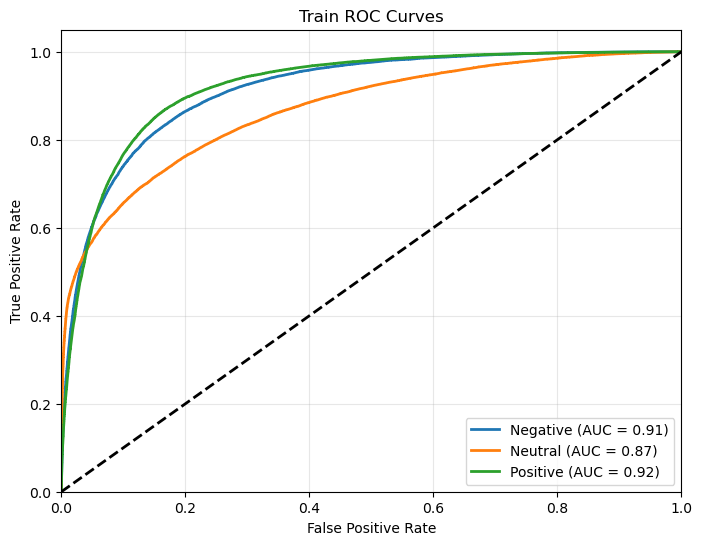

Validation ROC AUC:


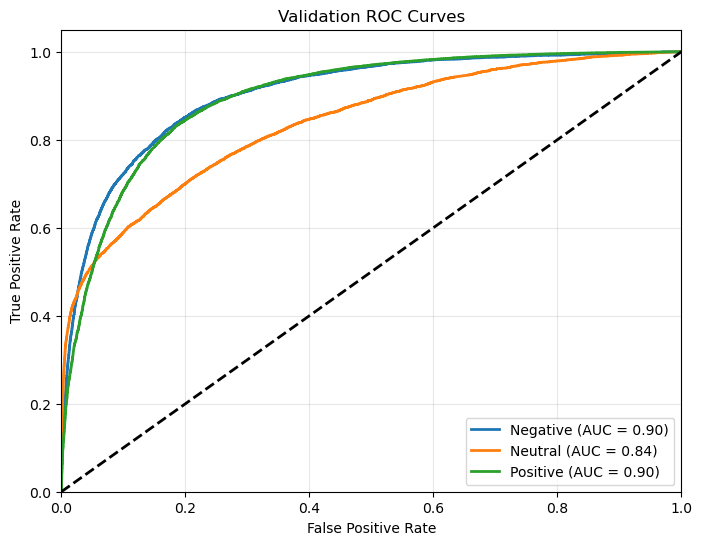

Test ROC AUC:


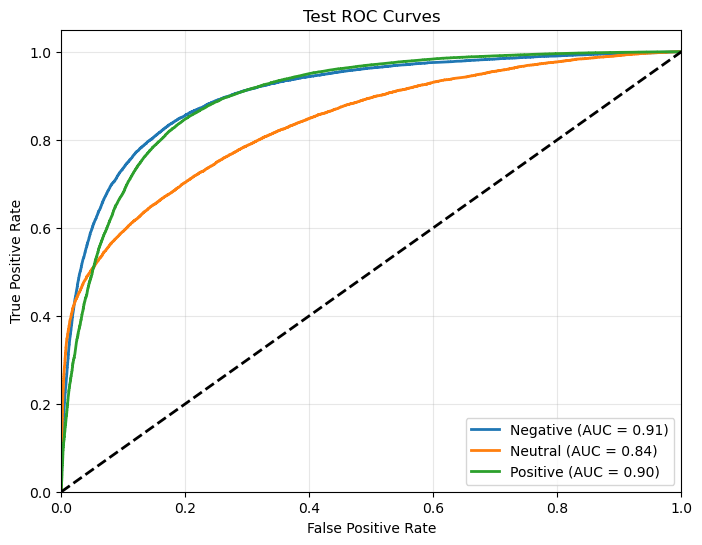

In [31]:
print("ROC AUC Curves for balanced dataset")
print("Train ROC AUC:")
plot_roc_auc(model, balanced_train_loader, device, label_encoder, title="Train ROC Curves")

print("Validation ROC AUC:")
plot_roc_auc(model, val_loader, device, label_encoder, title="Validation ROC Curves")

print("Test ROC AUC:")
plot_roc_auc(model, test_loader, device, label_encoder, title="Test ROC Curves")


In [43]:
!pip install lime


  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3bca3caa72bd7d189bc6449fbce609c14f211124aaa9b7f5660f57e33616d54c
  Stored in directory: /Users/mukulgarg/Library/Caches/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [47]:
from lime.lime_text import LimeTextExplainer
import torch
import numpy as np

# 1. Get class names from label_encoder
class_names = label_encoder.classes_

# 2. Define the prediction function for LIME
def predict_proba(texts):
    model.eval()
    
    # Convert texts to sequences using the fitted tokenizer
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences to max_len (same as training)
    padded = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')
    
    # Convert to tensor and move to device
    input_tensor = torch.tensor(padded).to(device)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    
    return probs



In [61]:
# 3. Initialize LIME text explainer
explainer = LimeTextExplainer(class_names=class_names)

# 4. Pick a sample text from your dataset
idx = 23  # Index of a sample tweet to explain
sample_text = df.iloc[idx]['clean_text']
print("Sample tweet:", sample_text)
# 5. Generate explanation
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)

# 6. Display explanation
exp.show_in_notebook(text=sample_text)

Sample tweet: belong jail vaccinemandate crimesagainsthumanity trudeaudictatorship freedomconvoy


# Hyperparameter Tuning


In [37]:
import torch
import torch.nn as nn

class SkorchNonCausalTransformer(nn.Module):
    def __init__(self, vocab_size=10000, embed_dim=64, num_heads=4, hidden_dim=128, num_layers=2, num_classes=3, max_len=250):
        super(SkorchNonCausalTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        positions = torch.arange(0, x.size(1)).unsqueeze(0).repeat(x.size(0), 1).to(x.device)
        x = self.embedding(x) + self.pos_embedding(positions)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)


In [38]:
!pip install skorch

In [39]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    SkorchNonCausalTransformer,
    module__vocab_size=vocab_size,
    module__num_classes=3,
    module__max_len=max_len,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    max_epochs=3,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0
)


In [40]:
from scipy.stats import randint, uniform

param_dist = {
    'module__embed_dim': randint(32, 129),
    'module__num_heads': randint(2, 5),
    'module__hidden_dim': randint(64, 257),
    'module__num_layers': randint(1, 4),
    'optimizer__lr': uniform(1e-4, 1e-2)
}


In [41]:
X_np = np.array(X_train_resampled)
y_np = np.array(y_train_resampled)


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from skorch.callbacks import EarlyStopping

rs = RandomizedSearchCV(
    net,
    param_distributions=param_dist,
    n_iter=10,  # adjust for more samples
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1,
    callbacks=[EarlyStopping(patience=2)]
)

rs.fit(X_np, y_np)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END module__embed_dim=83, module__hidden_dim=156, module__num_heads=4, module__num_layers=3, optimizer__lr=0.007896910002727693; total time=   0.1s
[CV] END module__embed_dim=83, module__hidden_dim=156, module__num_heads=4, module__num_layers=3, optimizer__lr=0.007896910002727693; total time=   0.1s
[CV] END module__embed_dim=91, module__hidden_dim=84, module__num_heads=2, module__num_layers=2, optimizer__lr=0.005347564316322379; total time=   0.1s
[CV] END module__embed_dim=52, module__hidden_dim=166, module__num_heads=3, module__num_layers=3, optimizer__lr=0.0010997491581800289; total time=   0.1s
[CV] END module__embed_dim=52, module__hidden_dim=166, module__num_heads=3, module__num_layers=3, optimizer__lr=0.0010997491581800289; total time=   0.1s
[CV] END module__embed_dim=52, module__hidden_dim=166, module__num_heads=3, module__num_layers=3, optimizer__lr=0.0010997491581800289; total time=   0.1s
[CV] END module__em

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[CV] END module__embed_dim=93, module__hidden_dim=114, module__num_heads=4, module__num_layers=1, optimizer__lr=0.0005645041271999773; total time=   0.0s
[CV] END module__embed_dim=91, module__hidden_dim=84, module__num_heads=2, module__num_layers=2, optimizer__lr=0.005347564316322379; total time=   0.1s
[CV] END module__embed_dim=91, module__hidden_dim=84, module__num_heads=2, module__num_layers=2, optimizer__lr=0.005347564316322379; total time=   0.1s
[CV] END module__embed_dim=35, module__hidden_dim=152, module__num_heads=3, module__num_layers=2, optimizer__lr=0.003954165025399161; total time=   0.1s
[CV] END module__embed_dim=35, module__hidden_dim=152, module__num_heads=3, module__num_layers=2, optimizer__lr=0.003954165025399161; total time=   0.0s
[CV] END module__embed_dim=35, module__hidden_dim=152, module__num_heads=3, module__num_layers=2, optimizer__lr=0.003954165025399161; total time=   0.0s


KeyboardInterrupt: 

In [ ]:
print("Best Parameters:\n", rs.best_params_)
print("Best CV Accuracy: ", rs.best_score_)

# Final tuned model
best_model = rs.best_estimator_
